## To compare different results 

In [52]:
from ast import literal_eval
from os import listdir
from os.path import isfile, join
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
import statistics as stats
import seaborn as sns
import datetime
import json
import numpy as np
import pandas as pd
import time
import yaml
import scipy.sparse as sparse
import matplotlib.pyplot as plt

## Dataset files 

In [2]:
#reviewJson = "..\\data\\Export_CleanedReview.json"
reviewJsonWithClosedRes = "..\\data\\Export_CleanedReviewWithClosedRes.json"

# with open(reviewJson, encoding = 'utf-8') as json_file:
#     data = json_file.readlines()
#     data = list(map(json.loads, data))

#This appeared to be a neasted list, just use data[0] to read
# df_review = pd.DataFrame(data[0])

## Load Data
Select top frenquent user and top frequenty restaurants that had at least 1 review >= 4 stars (Kickking out users that gave all  reviews <=3 and restaurants that never got start >= 4 stars)

In [3]:
def get_yelp_df(path = 'data/', filename = 'Export_CleanedReview.json', sampling=False, top_user_num=6100, top_item_num=4000):
    """
    Get the pandas dataframe
    Sampling only the top users/items by density 
    Implicit representation applies
    """
    with open(filename,'r') as f:
        data = f.readlines()
        data = list(map(json.loads, data))
    
    data = data[0]
    #Get all the data from the data file
    df = pd.DataFrame(data)
    
    df.rename(columns={'stars': 'review_stars', 'text': 'review_text', 'cool': 'review_cool',
                       'funny': 'review_funny', 'useful': 'review_useful'},
              inplace=True)

    df['business_num_id'] = df.business_id.astype('category').\
        cat.rename_categories(range(0, df.business_id.nunique()))
    df['business_num_id'] = df['business_num_id'].astype('int')

    df['user_num_id'] = df.user_id.astype('category').\
    cat.rename_categories(range(0, df.user_id.nunique()))
    df['user_num_id'] = df['user_num_id'].astype('int')

    df['timestamp'] = df['date'].apply(date_to_timestamp)

    if sampling:
        df = filter_yelp_df(df, top_user_num=top_user_num, top_item_num=top_item_num)
        # Refresh num id
        df['business_num_id'] = df.business_id.astype('category').\
        cat.rename_categories(range(0, df.business_id.nunique()))
        df['business_num_id'] = df['business_num_id'].astype('int')
        
        df['user_num_id'] = df.user_id.astype('category').\
        cat.rename_categories(range(0, df.user_id.nunique()))
        df['user_num_id'] = df['user_num_id'].astype('int')
#     drop_list = ['date','review_id','review_funny','review_cool','review_useful']
#     df = df.drop(drop_list, axis=1)

    df = df.reset_index(drop = True)

    return df 

def filter_yelp_df(df, top_user_num=6100, top_item_num=4000):
    #Getting the reviews where starts are above 3
    df_implicit = df[df['review_stars']>3]
    frequent_user_id = df_implicit['user_num_id'].value_counts().head(top_user_num).index.values
    frequent_item_id = df_implicit['business_num_id'].value_counts().head(top_item_num).index.values
    return df.loc[(df['user_num_id'].isin(frequent_user_id)) & (df['business_num_id'].isin(frequent_item_id))]

def date_to_timestamp(date):
    dt = datetime.datetime.strptime(date, '%Y-%m-%d')
    return time.mktime(dt.timetuple())

def df_to_sparse(df, row_name='userId', col_name='movieId', value_name='rating',
                 shape=None):
    rows = df[row_name]
    cols = df[col_name]
    if value_name is not None:
        values = df[value_name]
    else:
        values = [1]*len(rows)

    return csr_matrix((values, (rows, cols)), shape=shape)

## Get rating-UI and timestamp-UI matrix from original df

In [4]:
def get_rating_timestamp_matrix(df, sampling=False, top_user_num=6100, top_item_num=4000):
    """
    """
    #make the df implicit with top frenquent users and 
    #no need to sample anymore if df was sampled before 
    if sampling:
        df = filter_yelp_df(df, top_user_num=top_user_num, top_item_num=top_item_num)

    rating_matrix = df_to_sparse(df, row_name='user_num_id',
                                 col_name='business_num_id',
                                 value_name='review_stars',
                                 shape=None)
    
    #Have same dimension and data entries with rating_matrix, except that the review stars are - user avg
    ratingWuserAvg_matrix = df_to_sparse(df, row_name='user_num_id',
                                 col_name='business_num_id',
                                 value_name='reviewStars_userAvg',
                                 shape=None)
    
    timestamp_matrix = df_to_sparse(df, row_name='user_num_id',
                                    col_name='business_num_id',
                                    value_name='timestamp',
                                    shape=None)
    

    return rating_matrix, ratingWuserAvg_matrix, timestamp_matrix

## Time ordered split 

In [5]:
def time_ordered_split(rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, ratio=[0.5, 0.2, 0.3],
                       implicit=True, remove_empty=False, threshold=3,
                       sampling=False, sampling_ratio=0.1):
    """
    Split the data to train,valid,test by time
    ratio:  train:valid:test
    threshold: for implicit representation
    """
    if implicit:
        temp_rating_matrix = sparse.csr_matrix(rating_matrix.shape)
        temp_rating_matrix[(rating_matrix > threshold).nonzero()] = 1
        rating_matrix = temp_rating_matrix
        timestamp_matrix = timestamp_matrix.multiply(rating_matrix)
        #ratingWuserAvg_matrix = ratingWuserAvg_matrix.multiply(rating_matrix)

    nonzero_index = None

    #Default false, not removing empty columns and rows
    #Should not have this case, since users should have at least 1 record of 4,5 
    #And restuarant should have at least 1 record of 4,5 
    if remove_empty:
        # Remove empty columns. record original item index
        nonzero_index = np.unique(rating_matrix.nonzero()[1])
        rating_matrix = rating_matrix[:, nonzero_index]
        timestamp_matrix = timestamp_matrix[:, nonzero_index]
        ratingWuserAvg_matrix = ratingWuserAvg_matrix[:, nonzero_index]

        # Remove empty rows. record original user index
        nonzero_rows = np.unique(rating_matrix.nonzero()[0])
        rating_matrix = rating_matrix[nonzero_rows]
        timestamp_matrix = timestamp_matrix[nonzero_rows]
        ratingWuserAvg_matrix = ratingWuserAvg_matrix[nonzero_rows]

    user_num, item_num = rating_matrix.shape

    rtrain = []
    rtrain_userAvg = []
    rtime = []
    rvalid = []
    rvalid_userAvg = []
    rtest = []
    rtest_userAvg = []
    # Get the index list corresponding to item for train,valid,test
    item_idx_train = []
    item_idx_valid = []
    item_idx_test = []
    
    for i in tqdm(range(user_num)):
        #Get the non_zero indexs, restuarants where the user visited/liked if implicit 
        item_indexes = rating_matrix[i].nonzero()[1]
        
        #Get the data for the user
        data = rating_matrix[i].data
        
        #Get time stamp value 
        timestamp = timestamp_matrix[i].data
        
        #Get review stars with user avg data 
        if implicit == False:
            dataWuserAvg = ratingWuserAvg_matrix[i].data
        
        #Non zero reviews for this user
        num_nonzeros = len(item_indexes)
        
        #If the user has at least one review
        if num_nonzeros >= 1:
            #Get number of test and valid data 
            #train is 30%
            num_test = int(num_nonzeros * ratio[2])
            #validate is 50%
            num_valid = int(num_nonzeros * (ratio[1] + ratio[2]))

            valid_offset = num_nonzeros - num_valid
            test_offset = num_nonzeros - num_test

            #Sort the timestamp for each review for the user
            argsort = np.argsort(timestamp)
            
            #Sort the reviews for the user according to the time stamp 
            data = data[argsort]
            
            #Sort the review with user avg accoridng to the time stamp
            if implicit == False:
                dataWuserAvg = dataWuserAvg[argsort]
            
            #Non-zero review index sort according to time
            item_indexes = item_indexes[argsort]
            
            #list of ratings, num of valid_offset index, index where there's non-zeros
            rtrain.append([data[:valid_offset], np.full(valid_offset, i), item_indexes[:valid_offset]])
            
            if implicit == False:
                #Changing valid set to binary
                count=valid_offset
                for eachData in data[valid_offset:test_offset]:
                    #if rating-avgRating > 0 then like
                    if eachData >= 4:
                        data[count] = 1
                    else:
                        data[count] = 0
                    count += 1
                
            #50%-70%
            rvalid.append([data[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
                           item_indexes[valid_offset:test_offset]])
            #remaining 30%
            rtest.append([data[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
            
            if implicit == False:
                #Now for the rating matrix that considers user average rating
                #list of ratings, num of valid_offset index, index where there's non-zeros
                rtrain_userAvg.append([dataWuserAvg[:valid_offset], np.full(valid_offset, i), item_indexes[:valid_offset]])
                #50%-70%

                #Changing valid set to binary
                count=valid_offset
                for eachData in dataWuserAvg[valid_offset:test_offset]:
                    #if rating-avgRating > 0 then like
                    if eachData > 0:
                        dataWuserAvg[count] = 1
                    else:
                        dataWuserAvg[count] = 0
                    count += 1

                rvalid_userAvg.append([dataWuserAvg[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
                               item_indexes[valid_offset:test_offset]])

                #Change test set to binary even we don't use it
                countTest = test_offset
                for eachData in dataWuserAvg[test_offset:]:
                    #if rating-avgRating > 0 then like
                    if eachData > 0:
                        dataWuserAvg[count] = 1
                    else:
                        dataWuserAvg[count] = 0
                    count += 1


                #remaining 30%
                rtest_userAvg.append([dataWuserAvg[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
                
            item_idx_train.append(item_indexes[:valid_offset])
            
#             item_idx_valid.append(item_indexes[valid_offset:test_offset])
#             item_idx_test.append(item_indexes[test_offset:])
        else:
            item_idx_train.append([])
#             item_idx_valid.append([])
#             item_idx_test.append([])
    
    rtrain = np.array(rtrain)
    rvalid = np.array(rvalid)
    rtest = np.array(rtest)
    if implicit == False:
        rtrain_userAvg = np.array(rtrain_userAvg)
        rvalid_userAvg = np.array(rvalid_userAvg)
        rtest_userAvg = np.array(rtest_userAvg)

    #take non-zeros values, row index, and column (non-zero) index and store into sparse matrix
    rtrain = sparse.csr_matrix((np.hstack(rtrain[:, 0]), (np.hstack(rtrain[:, 1]), np.hstack(rtrain[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rvalid = sparse.csr_matrix((np.hstack(rvalid[:, 0]), (np.hstack(rvalid[:, 1]), np.hstack(rvalid[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rtest = sparse.csr_matrix((np.hstack(rtest[:, 0]), (np.hstack(rtest[:, 1]), np.hstack(rtest[:, 2]))),
                              shape=rating_matrix.shape, dtype=np.float32)
    
    if implicit == False:
        rtrain_userAvg = sparse.csr_matrix((np.hstack(rtrain_userAvg[:, 0]), (np.hstack(rtrain_userAvg[:, 1]), np.hstack(rtrain_userAvg[:, 2]))),
                                   shape=rating_matrix.shape, dtype=np.float32)
        rvalid_userAvg = sparse.csr_matrix((np.hstack(rvalid_userAvg[:, 0]), (np.hstack(rvalid_userAvg[:, 1]), np.hstack(rvalid_userAvg[:, 2]))),
                                   shape=rating_matrix.shape, dtype=np.float32)
        rtest_userAvg = sparse.csr_matrix((np.hstack(rtest_userAvg[:, 0]), (np.hstack(rtest_userAvg[:, 1]), np.hstack(rtest_userAvg[:, 2]))),
                                  shape=rating_matrix.shape, dtype=np.float32)

    return rtrain, rvalid, rtest,rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, timestamp_matrix, item_idx_train, item_idx_valid, item_idx_test

## Get df for training corpus

In [6]:
#Item idex matrix stores the reivews starts
#This function returns a list of index for the reviews included in training set 
def get_corpus_idx_list(df, item_idx_matrix):
    """
    Input: 
    df: total dataframe
    item_idx_matrix: train index list got from time_split 
    Output: row index in original dataframe for training data by time split
    """
    lst = []
    #For all the users: 5791
    for i in tqdm(range(len(item_idx_matrix))):
        
        #find row index where user_num_id is i
        a = df.index[df['user_num_id'] == i].tolist()
        
        #loop through the busienss id that the user i reviewed for in offvalid set 
        for item_idx in  item_idx_matrix[i]:
            
            #get the row index for reviews for business that the user liked in the train set
            b = df.index[df['business_num_id'] == item_idx].tolist()
            
            #Find the index for which this user liked, one user only rate a business once
            idx_to_add = list(set(a).intersection(b))
            
            if idx_to_add not in lst:
                lst.extend(idx_to_add)
    return lst

## Preprocess using Term Frequency - CounterVectorizer

In [7]:
#Stemming and Lemmatisation
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
# Get corpus and CountVector
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('wordnet')
nltk.download('stopwords')
lem = WordNetLemmatizer()
stem = PorterStemmer()
stop_words = set(stopwords.words("english"))
new_words = ['not_the']
stop_words = stop_words.union(new_words)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shenti10\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shenti10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from tqdm import tqdm

#Should 'because' added?
def preprocess(df, reset_list = [',','.','?',';','however','but']):
    corpus = []
    for i in tqdm(range(df.shape[0])):
        text = df['review_text'][i]
        change_flg = 0
        #Convert to lowercase
        text = text.lower()
        
        ##Convert to list from string, loop through the review text
        text = text.split()
        
        #any sentence that encounters a not, the folloing words will become not phrase until hit the sentence end
        for j in range(len(text)):
            #Make the not_ hack
            if text[j] == 'not':
                change_flg = 1
#                 print 'changes is made after ', i
                continue
            #if was 1 was round and not hit a 'not' in this round
            if change_flg == 1 and any(reset in text[j] for reset in reset_list):
                text[j] = 'not_' + text[j]
                change_flg = 0
#                 print 'reset at ', i
            if change_flg == 1:
                text[j] = 'not_' + text[j]
        
        #Convert back to string
        text = " ".join(text)
        
        #Remove punctuations
#       text = re.sub('[^a-zA-Z]', ' ', text)
        
        #remove tags
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
        
        # remove special characters and digits
        text=re.sub("(\\d|\\W)+"," ",text)
        
        ##Convert to list from string
        text = text.split()
        
        ##Stemming
        ps=PorterStemmer()
        
        #Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        corpus.append(text)
    return corpus

## All Model

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
def train(matrix_train):
    similarity = cosine_similarity(X=matrix_train, Y=None, dense_output=True)
    return similarity

def get_I_K(df, X, row_name = 'business_num_id', binary = True, shape = (121994,6000)):
    """
    get the item-keyphrase matrix
    """
    rows = []
    cols = []
    vals = []
    #For each review history
    for i in tqdm(range(X.shape[0])):
        #Get the array of frequencies for document/review i 
        arr = X[i].toarray() 
        nonzero_element = arr.nonzero()[1]  # Get nonzero element in each line, keyphrase that appears index 
        length_of_nonzero = len(nonzero_element) #number of important keyphrase that appears
        
        # df[row_name][i] is the item idex
        #Get a list row index that indicates the document/review
        rows.extend(np.array([df[row_name][i]]*length_of_nonzero)) ## Item index
        #print(rows)
        
        #Get a list of column index indicating the key phrase that appears in i document/review
        cols.extend(nonzero_element) ## Keyword Index
        if binary:
            #Create a bunch of 1s
            vals.extend(np.array([1]*length_of_nonzero))
        else:
            #If not binary 
            vals.extend(arr[arr.nonzero()])    
    return csr_matrix((vals, (rows, cols)), shape=shape)


#Get a UI matrix if it's not item_similarity based or else IU
def predict(matrix_train, k, similarity, item_similarity_en = False):
    prediction_scores = []
    
    #inverse to IU matrix
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    #for each user or item, depends UI or IU 
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores for all items
        #Get prediction/similarity score for each user 1*num or user or num of items
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        #Decending accoding to similarity score, select top k
        similar_users = vector_u.argsort()[::-1][1:k+1]
        
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        
        #similar_users_weights_sum = np.sum(similar_users_weights)
        #print(similar_users_weights.shape)
        #shape: num of res * k
        similar_users_ratings = matrix_train[similar_users].toarray()
              
        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
        #print(prediction_scores_u)
        
        
        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    return res

#Get a UI matrix if it's not item_similarity based or else IU
# def predictUU(matrix_train, k, similarity1, similarity2, similarity3, weight1, weight2, weight3, chooseWeigthMethod = 'max',  item_similarity_en = False):
#     prediction_scores = []
    
#     #inverse to IU matrix
#     if item_similarity_en:
#         matrix_train = matrix_train.transpose()
        
#     #for each user or item, depends UI or IU 
#     for user_index in tqdm(range(matrix_train.shape[0])):
#         # Get user u's prediction scores for all items
#         #Get prediction/similarity score for each user 1*num or user or num of items
#         vector_u = similarity[user_index]

#         # Get closest K neighbors excluding user u self
#         #Decending accoding to similarity score, select top k
#         similar_users = vector_u.argsort()[::-1][1:k+1]
        
#         # Get neighbors similarity weights and ratings
#         similar_users_weights = similarity[user_index][similar_users]
        
#         #similar_users_weights_sum = np.sum(similar_users_weights)
#         #print(similar_users_weights.shape)
#         #shape: num of res * k
#         similar_users_ratings = matrix_train[similar_users].toarray()
              
#         prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
#         #print(prediction_scores_u)
        
        
#         prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
#     res = np.array(prediction_scores)
    
#     if item_similarity_en:
#         res = res.transpose()
#     return res


# def predictII(matrix_train, k, similarity, item_similarity_en = False):
#     prediction_scores = []
    
#     #inverse to IU matrix
#     if item_similarity_en:
#         matrix_train = matrix_train.transpose()
        
#     #for each user or item, depends UI or IU 
#     for user_index in tqdm(range(matrix_train.shape[0])):
#         # Get user u's prediction scores for all items
#         #Get prediction/similarity score for each user 1*num or user or num of items
#         vector_u = similarity[user_index]

#         # Get closest K neighbors excluding user u self
#         #Decending accoding to similarity score, select top k
#         similar_users = vector_u.argsort()[::-1][1:k+1]
        
#         # Get neighbors similarity weights and ratings
#         similar_users_weights = similarity[user_index][similar_users]
        
#         #similar_users_weights_sum = np.sum(similar_users_weights)
#         #print(similar_users_weights.shape)
#         #shape: num of res * k
#         similar_users_ratings = matrix_train[similar_users].toarray()
              
#         prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
#         #print(prediction_scores_u)
        
        
#         prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
#     res = np.array(prediction_scores)
    
#     if item_similarity_en:
#         res = res.transpose()
#     return res



#Preidction score is UI or IU?
def prediction(prediction_score, topK, matrix_Train):

    prediction = []

    #for each user
    for user_index in tqdm(range(matrix_Train.shape[0])):
        
        #take the prediction scores for user 1 * num res
        vector_u = prediction_score[user_index]
        
        #The restuarant the user rated
        vector_train = matrix_Train[user_index]
        
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine(vector_u, vector_train, topK=topK)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return np.vstack(prediction)

#topK: the number of restuarants we are suggesting 
#if vector_train has number, then the user has visited
def sub_routine(vector_u, vector_train, topK=500):

    #index where non-zero
    train_index = vector_train.nonzero()[1]
    
    vector_u = vector_u
    
    #get topk + num rated res prediction score descending, top index 
    candidate_index = np.argpartition(-vector_u, topK+len(train_index))[:topK+len(train_index)]
    
    #sort top prediction score index in range topK+len(train_index) into vector_u`
    vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    
    #deleted the rated res from the topk+train_index prediction score vector for user u 
    #Delete the user rated res index from the topk+numRated index
    vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

    #so we only include the top K prediction score here
    return vector_u[:topK]

## Evaluation

In [9]:
def recallk(vector_true_dense, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_true_dense)


def precisionk(vector_predict, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_predict)


def average_precisionk(vector_predict, hits, **unused):
    precisions = np.cumsum(hits, dtype=np.float32)/range(1, len(vector_predict)+1)
    return np.mean(precisions)


def r_precision(vector_true_dense, vector_predict, **unused):
    vector_predict_short = vector_predict[:len(vector_true_dense)]
    hits = len(np.isin(vector_predict_short, vector_true_dense).nonzero()[0])
    return float(hits)/len(vector_true_dense)


def _dcg_support(size):
    arr = np.arange(1, size+1)+1
    return 1./np.log2(arr)


def ndcg(vector_true_dense, vector_predict, hits):
    idcg = np.sum(_dcg_support(len(vector_true_dense)))
    dcg_base = _dcg_support(len(vector_predict))
    dcg_base[np.logical_not(hits)] = 0
    dcg = np.sum(dcg_base)
    return dcg/idcg


def click(hits, **unused):
    first_hit = next((i for i, x in enumerate(hits) if x), None)
    if first_hit is None:
        return 5
    else:
        return first_hit/10


def evaluate(matrix_Predict, matrix_Test, metric_names =['R-Precision', 'NDCG', 'Precision', 'Recall', 'MAP'], atK = [5, 10, 15, 20, 50], analytical=False):
    """
    :param matrix_U: Latent representations of users, for LRecs it is RQ, for ALSs it is U
    :param matrix_V: Latent representations of items, for LRecs it is Q, for ALSs it is V
    :param matrix_Train: Rating matrix for training, features.
    :param matrix_Test: Rating matrix for evaluation, true labels.
    :param k: Top K retrieval
    :param metric_names: Evaluation metrics
    :return:
    """
    global_metrics = {
        #"R-Precision": r_precision,
        #"NDCG": ndcg,
        #"Clicks": click
    }

    local_metrics = {
        #"Precision": precisionk,
        #"Recall": recallk,
        "MAP": average_precisionk
    }

    output = dict()

    num_users = matrix_Predict.shape[0]

    for k in atK:

        local_metric_names = list(set(metric_names).intersection(local_metrics.keys()))
        results = {name: [] for name in local_metric_names}
        topK_Predict = matrix_Predict[:, :k]

        for user_index in tqdm(range(topK_Predict.shape[0])):
            vector_predict = topK_Predict[user_index]
            if len(vector_predict.nonzero()[0]) > 0:
                vector_true = matrix_Test[user_index]
                vector_true_dense = vector_true.nonzero()[1]
                hits = np.isin(vector_predict, vector_true_dense)

                if vector_true_dense.size > 0:
                    for name in local_metric_names:
                        results[name].append(local_metrics[name](vector_true_dense=vector_true_dense,
                                                                 vector_predict=vector_predict,
                                                                 hits=hits))
        results_summary = dict()
        if analytical:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = round(results[name],4)
        else:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = (round((np.average(results[name])),4),
                                                              round((1.96*np.std(results[name])/np.sqrt(num_users)),4))
        output.update(results_summary)

    global_metric_names = list(set(metric_names).intersection(global_metrics.keys()))
    results = {name: [] for name in global_metric_names}

    topK_Predict = matrix_Predict[:]

    for user_index in tqdm(range(topK_Predict.shape[0])):
        vector_predict = topK_Predict[user_index]

        if len(vector_predict.nonzero()[0]) > 0:
            vector_true = matrix_Test[user_index]
            vector_true_dense = vector_true.nonzero()[1]
            hits = np.isin(vector_predict, vector_true_dense)

            # if user_index == 1:
            #     import ipdb;
            #     ipdb.set_trace()

            if vector_true_dense.size > 0:
                for name in global_metric_names:
                    results[name].append(global_metrics[name](vector_true_dense=vector_true_dense,
                                                              vector_predict=vector_predict,
                                                              hits=hits))
    results_summary = dict()
    if analytical:
        for name in global_metric_names:
            results_summary[name] = round(results[name],4)
    else:
        for name in global_metric_names:
            results_summary[name] = (round(np.average(results[name]),4), round((1.96*np.std(results[name])/np.sqrt(num_users)),4))
    output.update(results_summary)

    return output

## Add 2 matrices

In [10]:
## Utility functions
#3906 restuarant, 3000 keyphrase, 5791 user 
def add_two_matrix(ratio, U_I_matrix,I_K_matrix, shape = (3906, 3000+5791)):
    # ratio determine Keywords/User in the matrix
    rows = []
    cols = []
    datas = []
    I_U_matrix = U_I_matrix.transpose()
    
    #for each restuarant
    for i in tqdm(range(I_K_matrix.shape[0])):
        #key phrase that this item has, column(key phrase) index
        nonzero1 = I_K_matrix[i].nonzero()
        
        #user that rated this item, column(user) index 
        nonzero2 = I_U_matrix[i].nonzero()
        
        #Trying to create a sparse matrix that stores 
        #index of restuarant for (K + U) times
        row = [i]*(len(nonzero1[1])+len(nonzero2[1]))
        
        #column index for key phrase and users that are non-zero
        col = nonzero1[1].tolist()+ nonzero2[1].tolist()
        
        
        data = [ratio]*len(nonzero1[1])+[1-ratio]*len(nonzero2[1]) # Binary representation of I-K/U matrix
        
        rows.extend(row)
        cols.extend(col)
        datas.extend(data)
    return csr_matrix( (datas,(rows,cols)), shape=shape )

def transfer_to_implicit(rating_matrix, threshold = 0):
    temp_rating_matrix = sparse.csr_matrix(rating_matrix.shape)
    temp_rating_matrix[(rating_matrix > threshold).nonzero()] = 1
    rating_matrix = temp_rating_matrix
    return rating_matrix

#### Get original dataframe out of the review datastet

In [11]:
#Getting the yelp data -> reviews, only get the data for the top frequent users & restuarants that had a history of rating > 3
df = get_yelp_df(path ='', filename=reviewJsonWithClosedRes, sampling= True)

In [12]:
df['reviewStars_userAvg'] = df['review_stars'] - df['user_avg_stars']
df.loc[df['reviewStars_userAvg'] == 0, "reviewStars_userAvg"] = 0.01
#(df['reviewStars_userAvg'] == 0.01).sum()

In [82]:
#(df['reviewStars_userAvg'] == 0.01).sum()

1074

#### Get rating-UI matrix and timestepm-UI matrix

In [13]:
rating_matrix, ratingWuserAvg_matrix, timestamp_matrix = get_rating_timestamp_matrix(df)
# rating_matrix
# ratingWuserAvg_matrix

#### Split to get rtrain-UI matrix and valid and test.. item_index_matrix_train

In [14]:
rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_split(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=False)  

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 3832.52it/s]


In [15]:
rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_split(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  # This is added back by InteractiveShellApp.init_path()
100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4596.28it/s]


#### Get df shrink to df_train for rtrain

In [16]:
#Get the list of row index for the training set 
lst_train = get_corpus_idx_list(df, item_idx_matrix_train)

# Get the training dataframe from the original dataframe
df_train = df.loc[lst_train]

#Resetting the index of the train data
df_train = df_train.reset_index(drop=True)

df_train.shape

100%|██████████████████████████████████████████████████████████████████████████████| 6085/6085 [02:35<00:00, 39.20it/s]


(130953, 15)

#### If using term frequency only to compute corpus and X(review vs. terms) CounterVectorizer

In [19]:
# The entire corpus
#corpus = preprocess(df_train)
# X row: df_train row, column: key words frequency 
# When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
#cv=CountVectorizer(max_df=0.9,stop_words=stop_words, max_features=5000, ngram_range=(1,1))
#X=cv.fit_transform(corpus)

##### If using TD-IDF to compute corpus and X (business vs. terms) TfIdfVectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
corpus = preprocess(df_train)

100%|████████████████████████████████████████████████████████████████████████| 125794/125794 [00:47<00:00, 2662.22it/s]


In [22]:
#Creating a dictionary to store business: review text
dict_text = {}
for i in range(len(corpus)):
    if df_train['business_num_id'][i] not in dict_text:
        dict_text[df_train['business_num_id'][i]] = corpus[i]
    else:
        temp = dict_text[df_train['business_num_id'][i]]
        temp = temp + corpus[i]
        dict_text[df_train['business_num_id'][i]] = temp

In [23]:
#Create a list for the review text, where the row dimension = total business ids
list_text = []
for key in range(0,max(list(dict_text.keys()))+1) :
    if key not in dict_text.keys():
        list_text.extend([""])
    else:
        list_text.extend([dict_text[key]])

In [24]:
#Get the X vector, where dimension is #business vs #terms
vectorizer = TfidfVectorizer(max_df=0.9,stop_words=stop_words, max_features=5000, ngram_range=(1,1))
X_cleaned = vectorizer.fit_transform(list_text).toarray()
X_cleaned_sparse = csr_matrix(X_cleaned)

## User-rating KNN

### 1. With ratings that subtracts user average rating, cosine similarity

In [55]:
similarity1 = train(rtrain)
MAP10 = {}
for k in range(50, 120, 10):
    user_item_prediction_score1 = predict(rtrain_userAvg, k, similarity1, item_similarity_en= False)
    user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain_userAvg)
    user_item_res1 = evaluate(user_item_predict1, rvalid_userAvg)
    
    MAP10[k] = user_item_res1.get('MAP@10')[0]

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9160.71it/s]


In [56]:
MAP10

{50: 0.0419,
 60: 0.0422,
 70: 0.0424,
 80: 0.0429,
 90: 0.0432,
 100: 0.0439,
 110: 0.0432}

## Implicit

In [212]:
similarity1 = train(rtrain_implicit)
MAP10Implicit = {}
for k in range(50, 120, 10):
    user_item_prediction_score1 = predict(rtrain_implicit, k, similarity1, item_similarity_en= False)
    user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain_implicit)
    user_item_res1 = evaluate(user_item_predict1, rvalid_implicit)
    
    MAP10Implicit[k] = user_item_res1.get('MAP@10')[0]

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9078.87it/s]


## Implicit similarity + explicit prediction matrix

In [269]:
similarity1 = train(rtrain_implicit)
MAP10Combine = {}
for k in range(40, 120, 10):
    user_item_prediction_score1 = predict(rtrain, k, similarity1, item_similarity_en= False)
    user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
    user_item_res1 = evaluate(user_item_predict1, rvalid)
    
    MAP10Combine[k] = user_item_res1.get('MAP@10')[0]

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9038.53it/s]


In [270]:
MAP10Combine

{40: 0.1047,
 50: 0.1061,
 60: 0.1066,
 70: 0.1067,
 80: 0.1059,
 90: 0.1052,
 100: 0.1044,
 110: 0.104}

## Plot for combined KNN, implicit similarity matrix, explicit user-rating matrix

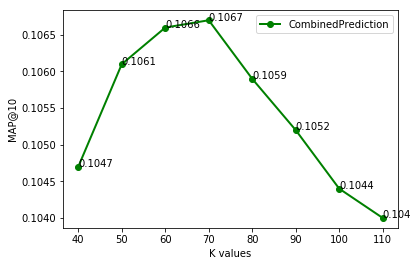

In [276]:
listsCombined = sorted(MAP10Combine.items()) # sorted by key, return a list of tuples

x1, y1 = zip(*listsCombined) # unpack a list of pairs into two tuples

plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="CombinedPrediction")
for x, y in zip(x1, y1): 
    plt.text(x, y, str(y))
    
plt.legend()
plt.xlabel('K values')
plt.ylabel('MAP@10')

plt.show()

### 2. With ratings that subtracts user average rating, pearson correlation

In [30]:
# #UU similarity, using cosine similarity
# similarity2 = train(rtrain_userAvg)
# #get a user-item matrix  UI prediction
# #Predict using UI matrix with ratings in it 
# user_item_prediction_score2 = predict(rtrain_userAvg, 100, similarity2, item_similarity_en= False)
# user_item_predict2 = prediction(user_item_prediction_score2, 50, rtrain_userAvg)
# user_item_res2 = evaluate(user_item_predict2, rvalid_userAvg)
# user_item_res2

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4412.00it/s]


### 3. With raw ratings, cosinesimilarity

In [41]:
similarity3 = train(rtrain)
MAP10ExplicitRaw = {}
for k in range(50, 120, 10):
    user_item_prediction_score3 = predict(rtrain, k, similarity3, item_similarity_en= False)
    user_item_predict3 = prediction(user_item_prediction_score3, 50, rtrain)
    user_item_res3 = evaluate(user_item_predict3, rvalid)
    
    MAP10ExplicitRaw[k] = user_item_res3.get('MAP@10')[0]

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9012.40it/s]


In [44]:
MAP10ExplicitRaw.values()

dict_values([0.0535, 0.0532, 0.0538, 0.0537, 0.0539, 0.0537, 0.0536])

## User-visting matrix

In [45]:
def getImplicitMatrix(sparseMatrix, threashold=0):
    temp_matrix = sparse.csr_matrix(sparseMatrix.shape)
    temp_matrix[(sparseMatrix > threashold).nonzero()] = 1
    return temp_matrix

userVisitMatrix = getImplicitMatrix(rtrain)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
MAP10UserVisit = {}
for k in range(50, 120, 10):
    similarity3 = train(userVisitMatrix)
    user_item_prediction_score3 = predict(userVisitMatrix, k, similarity3, item_similarity_en= False)
    user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
    user_item_res3 = evaluate(user_item_predict3, rvalid_implicit)
    
    MAP10UserVisit[k] = user_item_res3.get('MAP@10')[0]

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9300.79it/s]


In [258]:
MAP10UserVisit.values()

dict_values([0.0464, 0.0467, 0.0469, 0.0471, 0.0471, 0.0472, 0.0472])

## plot for best k 

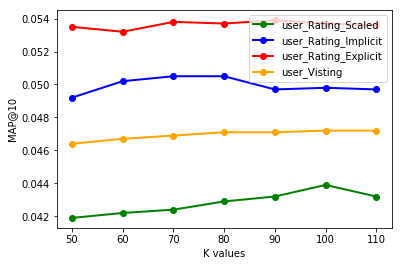

In [277]:
listsUserRatingScaled = sorted(MAP10.items()) # sorted by key, return a list of tuples
listsUserRatingImplicit = sorted(MAP10Implicit.items())
listsUserRatingExplicitRaw = sorted(MAP10ExplicitRaw.items())
listsUserRatingUserVisiting = sorted(MAP10UserVisit.items())

x1, y1 = zip(*listsUserRatingScaled) # unpack a list of pairs into two tuples
x2, y2 = zip(*listsUserRatingImplicit)
x3, y3 = zip(*listsUserRatingExplicitRaw)
x4, y4 = zip(*listsUserRatingUserVisiting)


plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="user_Rating_Scaled")
plt.plot( x2, y2, marker='o', color='blue', linewidth=2, label="user_Rating_Implicit")
plt.plot( x3, y3, marker='o', color='red', linewidth=2, label="user_Rating_Explicit")
plt.plot( x4, y4, marker='o', color='orange', linewidth=2, label="user_Visting")
plt.legend()
plt.xlabel('K values')
plt.ylabel('MAP@10')

plt.show()

## Item Base KNN using TF-IDF

In [48]:
IK_MATRIX = X_cleaned_sparse

In [49]:
I_I_similarity = train(IK_MATRIX)
item_based_prediction_score4 = predict(rtrain, 10, I_I_similarity, item_similarity_en= True)
#for each restuarant top50 users 
item_based_predict4 = prediction(item_based_prediction_score4, 50, rtrain)

100%|████████████████████████████████████████████████████████████████████████████| 6088/6088 [00:01<00:00, 3433.24it/s]


In [51]:
item_based_res_TFIDF = evaluate(item_based_predict4, rvalid)

100%|████████████████████████████████████████████████████████████████████████████| 6088/6088 [00:00<00:00, 6098.03it/s]


In [52]:
item_based_res_TFIDF

{'MAP@5': (0.025720090045571842, 0.0023778194577824324),
 'Recall@5': (0.016655483869688705, 0.0017397463525098502),
 'Precision@5': (0.022467468291879424, 0.0017674622991041998),
 'MAP@10': (0.022609687481207827, 0.0017360525467602446),
 'Recall@10': (0.027194281753721176, 0.002222645640702759),
 'Precision@10': (0.018283643551309504, 0.0011753292576658),
 'MAP@15': (0.020781676396896296, 0.00142907310519044),
 'Recall@15': (0.036517627228885796, 0.0025924958256981607),
 'Precision@15': (0.0165266567836161, 0.0009373298279886963),
 'MAP@20': (0.019509841866004404, 0.0012405775324402586),
 'Recall@20': (0.044301527297699116, 0.002866338517957658),
 'Precision@20': (0.015112831493987811, 0.0007917345810550951),
 'MAP@50': (0.015555777760667203, 0.0007797415508435789),
 'Recall@50': (0.08003652685068291, 0.003781329780486565),
 'Precision@50': (0.011391862955032118, 0.0004649805491420753),
 'R-Precision': (0.019076629311042183, 0.0015214914170442837),
 'NDCG': (0.04568113642606309, 0.002

## Try combining different similarity scores

In [331]:
#Get a UI matrix if it's not item_similarity based or else IU
def predictUU(matrix_train, k, similarity1=None, similarity2=None, similarity3=None, similarity4=None, chooseWeigthMethod = 'max', item_similarity_en = False):
    prediction_scores = []
    #Convert from list to ndarray, add an axis
    #chooseWeigthMethod = 'max'
    if isinstance(chooseWeigthMethod, list):
        chooseWeigthMethod = np.array(chooseWeigthMethod)[:, np.newaxis]
   
    "make sure that when passing in chooseWeightMethod, the weight must be aligned with similarity metrices, even if set to None"
    "They should add to 1 as well"
    #inverse to IU matrix
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    #for each user or item, depends UI or IU 
    for user_index in tqdm(range(matrix_train.shape[0])):
    #for user_index in tqdm(range(10,20)):
        
        numberSimilarMatrix = 0
        # Get user u's prediction scores for all items 
        #Get prediction/similarity score for each user 1*num or user or num of items
        if similarity1 is not None:
            vector_u1 = similarity1[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u1 = [0]*matrix_train.shape[0]
            
        if similarity2 is not None:
            vector_u2 = similarity2[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u2 = [0]*len(vector_u1)
            
        if similarity3 is not None:
            vector_u3 = similarity3[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u3 = [0]*len(vector_u1)
            
        if similarity4 is not None:
            vector_u4 = similarity4[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u4 = [0]*len(vector_u1)
        
        #Temperary vector that stacks all 4 vectors together
        tempVector = np.array([vector_u1,vector_u2,vector_u3,vector_u4])
        
        if chooseWeigthMethod is None:
            #Get the similarity score from the first similarity matrix anyways 
            vector_u = vector_u1.copy()
            
        #If we are choosing the max, min, avg or similarity scores
        if chooseWeigthMethod is not None:
            if chooseWeigthMethod == 'max':
                vector_u = tempVector.max(axis=0)
            elif chooseWeigthMethod == 'min':
                vector_u = tempVector.min(axis=0)
            elif chooseWeigthMethod == 'average':
                vector_u = tempVector.mean(axis=0)
            elif isinstance(chooseWeigthMethod, np.ndarray):
                #Validate that number of weights passed in equals number of matrices
                #assert(len(chooseWeigthMethod) == numberSimilarMatrix)
                #Get the new combined similarity vector 
                weighted_u = tempVector * chooseWeigthMethod
                vector_u =np.sum(weighted_u, axis=0)
                #print((vector_u == vector_u4).sum())
                
        similar_users = vector_u.argsort()[::-1][1:k+1]
        
        # Get neighbors similarity weights and ratings
        #similar_users_weights = similarity1[user_index][similar_users]
        similar_users_weights = vector_u[similar_users]
        
        #similar_users_weights_sum = np.sum(similar_users_weights)
        #print(similar_users_weights.shape)
        #shape: num of res * k
        similar_users_ratings = matrix_train[similar_users].toarray()
              
        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
        #print(prediction_scores_u)
        
        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    return res
    #return vector_u

In [256]:
#UU similarity, using cosine similarity
similarity1 = train(rtrain)
similarity2 = train(rtrain_userAvg)
#similarity2 = None
similarity3 =train(userVisitMatrix)
#similarity3 = None
similarity4 = train(rtrain_implicit)
#similarity4 = None
#vectorU = predictUU(rtrain_userAvg, 90, similarity1, similarity2, similarity3, weight1, weight2, weight3, item_similarity_en= False)
user_item_prediction_score1 = predictUU(rtrain, 90, similarity1, similarity2, similarity3, similarity4, chooseWeigthMethod = [0,0,0,1], item_similarity_en= False)
user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
user_item_res1 = evaluate(user_item_predict1, rvalid)

  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9343.10it/s]


## Iterations for different combination 

In [335]:
#UU similarity, using cosine similarity
similarity1 = train(rtrain)
similarity2 = train(rtrain_userAvg)
#similarity2 = None
similarity3 =train(userVisitMatrix)
#similarity3 = None
similarity4 = train(rtrain_implicit)

predictionMatrixDict = {'prediction1':rtrain, 
                        'prediction2': rtrain_userAvg, 
                        'prediction3:': userVisitMatrix, 
                        'prediction4': rtrain_implicit}

SimilarityMatrixIndex = {1: [similarity1, None],
                         2: [similarity2, None],
                         3: [similarity3, None],
                         4: [similarity4, None]} 
combinationDict = {
    'comb1': [1, 2, 3, 4],
    'comb2': [1, 2, 3],
    'comb3': [1, 2, 4],
    'comb4': [2, 3, 4],
    'comb5': [1, 3, 4],
    'comb6': [1, 2],
    'comb7': [1, 3],
    'comb8': [1, 4],
    'comb9': [2, 3],
    'comb10': [2, 4],
    'combe11':[3,4]
    }

### Max

#### Prediction 1: rtrain; explicit raw rating


In [334]:
prediction1 = {}
for combination, indexList in combinationDict.items():
    #Loop through the similarity matrices 
    for index in SimilarityMatrixIndex.keys():
        if index in indexList:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][0]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][0]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][0]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][0]
        else:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
                 
    user_item_prediction_score = predictUU(rtrain, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='max', item_similarity_en= False)
    user_item_predict = prediction(user_item_prediction_score, 50, rtrain)
    user_item_res = evaluate(user_item_predict, rvalid)
            

    prediction1[combination] = user_item_res.get('MAP@10')[0]

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 7152.64it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8728.36it/s]


#### Prediction 2: explicit user rating, with user average

In [356]:
prediction2 = {}
for combination, indexList in combinationDict.items():
    #Loop through the similarity matrices 
    for index in SimilarityMatrixIndex.keys():
        if index in indexList:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][0]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][0]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][0]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][0]
        else:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
                 
    user_item_prediction_score = predictUU(rtrain_userAvg, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='max', item_similarity_en= False)
    user_item_predict = prediction(user_item_prediction_score, 50, rtrain_userAvg)
    user_item_res = evaluate(user_item_predict, rvalid_userAvg)
            

    prediction2[combination] = user_item_res.get('MAP@10')[0]

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 7086.15it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9160.89it/s]


#### Prediction 3:user-visiting matrix

In [357]:
prediction3 = {}
for combination, indexList in combinationDict.items():
    #Loop through the similarity matrices 
    for index in SimilarityMatrixIndex.keys():
        if index in indexList:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][0]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][0]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][0]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][0]
        else:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
                 
    user_item_prediction_score = predictUU(userVisitMatrix, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='max', item_similarity_en= False)
    user_item_predict = prediction(user_item_prediction_score, 50, userVisitMatrix)
    user_item_res = evaluate(user_item_predict, rvalid_implicit)
            

    prediction3[combination] = user_item_res.get('MAP@10')[0]

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6965.02it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9161.27it/s]


#### Prediction 4: Implicit user rating

In [358]:
prediction4 = {}
for combination, indexList in combinationDict.items():
    #Loop through the similarity matrices 
    for index in SimilarityMatrixIndex.keys():
        if index in indexList:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][0]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][0]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][0]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][0]
        else:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
                 
    user_item_prediction_score = predictUU(rtrain_implicit, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='max', item_similarity_en= False)
    user_item_predict = prediction(user_item_prediction_score, 50, rtrain_implicit)
    user_item_res = evaluate(user_item_predict, rvalid_implicit)
            

    prediction4[combination] = user_item_res.get('MAP@10')[0]

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 7053.64it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9202.26it/s]


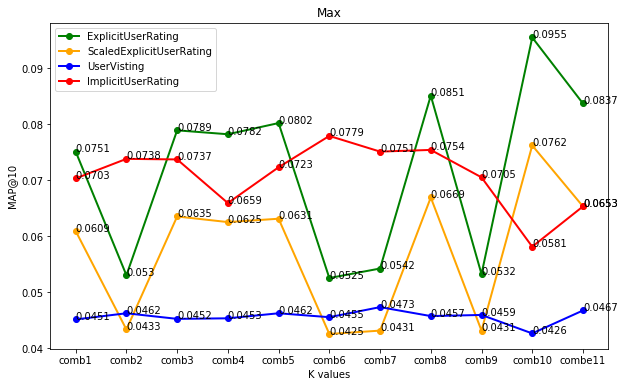

In [363]:
listPrediction1 = prediction1.items() # sorted by key, return a list of tuples
listPrediction2 = prediction2.items()
listPrediction3 = prediction3.items()
listPrediction4 = prediction4.items()

x1, y1 = zip(*listPrediction1) # unpack a list of pairs into two tuples
x2, y2 = zip(*listPrediction2)
x3, y3 = zip(*listPrediction3)
x4, y4 = zip(*listPrediction4)

plt.figure(figsize=(10,6))
plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="ExplicitUserRating")
plt.plot( x2, y2, marker='o',color='orange', linewidth=2, label="ScaledExplicitUserRating")
plt.plot( x3, y3, marker='o',color='blue', linewidth=2, label="UserVisting")
plt.plot( x4, y4, marker='o',color='red', linewidth=2, label="ImplicitUserRating")

for x, y in zip(x1, y1): 
    plt.text(x, y, str(y))
for x, y in zip(x2, y2): 
    plt.text(x, y, str(y))
for x, y in zip(x3, y3): 
    plt.text(x, y, str(y))
for x, y in zip(x4, y4): 
    plt.text(x, y, str(y))
      
plt.title('Max')
plt.legend()
plt.xlabel('K values')
plt.ylabel('MAP@10')
plt.show()

### Min

In [295]:
for key in SimilarityMatrixIndex.keys():
    print(key)

1
2
3
4


In [300]:
1 in SimilarityMatrixIndex.keys()

True

### Average

In [257]:
user_item_res1

{'MAP@5': (0.1314, 0.0053),
 'MAP@10': (0.1052, 0.0038),
 'MAP@15': (0.0913, 0.003),
 'MAP@20': (0.0823, 0.0026),
 'MAP@50': (0.0581, 0.0016)}

In [209]:
user_item_res1  #1,4, [0.1,0.9]

{'MAP@5': (0.1228, 0.0051),
 'MAP@10': (0.0992, 0.0036),
 'MAP@15': (0.0866, 0.0029),
 'MAP@20': (0.0785, 0.0025),
 'MAP@50': (0.0562, 0.0015)}

In [86]:
user_item_res1

{'MAP@5': (0.102, 0.0046),
 'MAP@10': (0.0851, 0.0033),
 'MAP@15': (0.0758, 0.0027),
 'MAP@20': (0.0696, 0.0023),
 'MAP@50': (0.0518, 0.0014)}

In [205]:
user_item_res1   #1,4, max rtrain,rvalid

{'MAP@5': (0.102, 0.0046),
 'MAP@10': (0.0851, 0.0033),
 'MAP@15': (0.0758, 0.0027),
 'MAP@20': (0.0696, 0.0023),
 'MAP@50': (0.0518, 0.0014)}

In [203]:
user_item_res1   #1,2,3,4 max rtrain,rvalid

{'MAP@5': (0.0872, 0.0042),
 'MAP@10': (0.075, 0.0031),
 'MAP@15': (0.0681, 0.0025),
 'MAP@20': (0.0632, 0.0022),
 'MAP@50': (0.0486, 0.0013)}

In [201]:
user_item_res1  #1,2,3,4, average  rtrain, rvalid 

{'MAP@5': (0.0687, 0.0037),
 'MAP@10': (0.0622, 0.0028),
 'MAP@15': (0.0579, 0.0023),
 'MAP@20': (0.0546, 0.002),
 'MAP@50': (0.0438, 0.0013)}

In [199]:
user_item_res1  #1,4 average rtrain_implicit 

{'MAP@5': (0.0698, 0.0038),
 'MAP@10': (0.0616, 0.0027),
 'MAP@15': (0.0568, 0.0022),
 'MAP@20': (0.0533, 0.0019),
 'MAP@50': (0.0426, 0.0012)}

In [197]:
user_item_res1  #1,4 average, rtrain_userAvg

{'MAP@5': (0.0658, 0.0037),
 'MAP@10': (0.057, 0.0027),
 'MAP@15': (0.0515, 0.0022),
 'MAP@20': (0.0477, 0.0019),
 'MAP@50': (0.0362, 0.0012)}

In [195]:
user_item_res1  #1,4 average rtrain, rvalid

{'MAP@5': (0.0844, 0.0042),
 'MAP@10': (0.073, 0.0031),
 'MAP@15': (0.0664, 0.0025),
 'MAP@20': (0.0617, 0.0022),
 'MAP@50': (0.0477, 0.0014)}

In [192]:
user_item_res1    #1,4 average with userVisitMatrix, rvalid 

{'MAP@5': (0.0797, 0.0041),
 'MAP@10': (0.069, 0.003),
 'MAP@15': (0.063, 0.0024),
 'MAP@20': (0.0588, 0.0021),
 'MAP@50': (0.0458, 0.0013)}

In [190]:
user_item_res1

{'MAP@5': (0.0572, 0.0035),
 'MAP@10': (0.0498, 0.0025),
 'MAP@15': (0.0455, 0.0021),
 'MAP@20': (0.0425, 0.0018),
 'MAP@50': (0.0331, 0.0011)}

In [188]:
user_item_res1 #average 1,4 similarity matrices

{'MAP@5': (0.0709, 0.0039),
 'MAP@10': (0.0612, 0.0028),
 'MAP@15': (0.0558, 0.0023),
 'MAP@20': (0.052, 0.002),
 'MAP@50': (0.0402, 0.0013)}

In [186]:
user_item_res1 #average 1,2,4 similarity matrices

{'MAP@5': (0.061, 0.0036),
 'MAP@10': (0.0545, 0.0026),
 'MAP@15': (0.0504, 0.0022),
 'MAP@20': (0.0474, 0.0019),
 'MAP@50': (0.0379, 0.0012)}

In [183]:
user_item_res1    #average 1-2 similarity matrices

{'MAP@5': (0.0447, 0.0031),
 'MAP@10': (0.0421, 0.0023),
 'MAP@15': (0.0402, 0.0019),
 'MAP@20': (0.0386, 0.0017),
 'MAP@50': (0.0324, 0.0011)}

In [181]:
user_item_res1   #average 3 1-3similarity matrices

{'MAP@5': (0.0469, 0.0031),
 'MAP@10': (0.0442, 0.0023),
 'MAP@15': (0.0421, 0.002),
 'MAP@20': (0.0403, 0.0017),
 'MAP@50': (0.0335, 0.0011)}

In [173]:
user_item_res1  #average 4, 1-4similarity matrices

{'MAP@5': (0.0577, 0.0035),
 'MAP@10': (0.0522, 0.0026),
 'MAP@15': (0.0486, 0.0021),
 'MAP@20': (0.0459, 0.0019),
 'MAP@50': (0.037, 0.0012)}

In [160]:
user_item_res1   #min

{'MAP@5': (0.0455, 0.0031),
 'MAP@10': (0.0425, 0.0023),
 'MAP@15': (0.0403, 0.0019),
 'MAP@20': (0.0384, 0.0017),
 'MAP@50': (0.032, 0.0011)}

In [155]:
user_item_res1 #max

{'MAP@5': (0.0738, 0.004),
 'MAP@10': (0.0635, 0.0029),
 'MAP@15': (0.0576, 0.0023),
 'MAP@20': (0.0534, 0.002),
 'MAP@50': (0.041, 0.0012)}

In [132]:
user_item_res1  #rtrain

{'MAP@5': (0.0505, 0.0032),
 'MAP@10': (0.0468, 0.0024),
 'MAP@15': (0.0443, 0.002),
 'MAP@20': (0.0422, 0.0018),
 'MAP@50': (0.0349, 0.0012)}

In [130]:
user_item_res1 #rtrain_userAvg

{'MAP@5': (0.0483, 0.0031),
 'MAP@10': (0.0433, 0.0023),
 'MAP@15': (0.0401, 0.0019),
 'MAP@20': (0.0377, 0.0017),
 'MAP@50': (0.0301, 0.0011)}

In [83]:
rtrain_userAvg[0][0].toarray()

array([[0.08, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float32)

In [81]:
rtrain_userAvg.shape

(6085, 4000)

In [42]:
def getImplicitMatrix(sparseMatrix, threashold=0):
    temp_matrix = sparse.csr_matrix(sparseMatrix.shape)
    temp_matrix[(sparseMatrix > threashold).nonzero()] = 1
    return temp_matrix

userVisitMatrix = getImplicitMatrix(rtrain)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  This is separate from the ipykernel package so we can avoid doing imports until


In [157]:
#UU similarity
similarity3 = train(userVisitMatrix)
#get a user-item matrix  UI prediction
#Predict using UI matrix with ratings in it 
user_item_prediction_score3 = predict(userVisitMatrix, 90, similarity3, item_similarity_en= False)
user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
#Check user item prediction score
user_item_res3 = evaluate(user_item_predict3, rvalid)

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9092.89it/s]


In [158]:
user_item_res3

{'MAP@5': (0.056, 0.0034),
 'MAP@10': (0.0521, 0.0025),
 'MAP@15': (0.0493, 0.0021),
 'MAP@20': (0.0471, 0.0019),
 'MAP@50': (0.0393, 0.0012)}

In [90]:
rtrain[0].toarray()

array([[4., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [101]:
for user_index in tqdm(range(2)):
    print(user_index)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

0
1


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2006.36it/s]


In [118]:
userVisitMatrix.shape

(6085, 4000)

In [119]:
rtrain.shape

(6085, 4000)

In [156]:
max(5,8,9,10)

10

In [164]:
stats.mean([1,1,1,1])

1

In [185]:
max([5,10,2], [10,5,9], [2,5,13])

[10, 5, 9]

In [69]:
a = np.array([[10, 2, 100], [3, 4, 50], [5, 6,40]])

In [70]:
a

array([[ 10,   2, 100],
       [  3,   4,  50],
       [  5,   6,  40]])

In [83]:
a.mean(axis=0)

array([ 6.        ,  4.        , 63.33333333])

In [98]:
flag = isinstance(["10","50","20"], list)
print(flag)

True


In [95]:
type([10,50,20])

list

In [99]:
a

array([[ 10,   2, 100],
       [  3,   4,  50],
       [  5,   6,  40]])

In [100]:
b = [3,4,2]

In [103]:
type(b)

list

In [106]:
(a * b).sum(axis=0)

array([ 54,  48, 380])

In [107]:
a * b

array([[ 30,   8, 200],
       [  9,  16, 100],
       [ 15,  24,  80]])

(3, 1)